## Fine-tune SegFormer on a custom dataset

In this notebook, we are going to fine-tune [SegFormerForSemanticSegmentation](https://huggingface.co/docs/transformers/main/model_doc/segformer#transformers.SegformerForSemanticSegmentation) on a custom **semantic segmentation** dataset. In semantic segmentation, the goal for the model is to label each pixel of an image with one of a list of predefined classes.

We load the encoder of the model with weights pre-trained on ImageNet-1k, and fine-tune it together with the decoder head, which starts with randomly initialized weights.

In [1]:
!pip install -q transformers datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 13.8 MB/s eta 0:00:00


## Download toy dataset

Here we download a small subset of the ADE20k dataset, which is an important benchmark for semantic segmentation. It contains 150 labels.

I've made a small subset just for demonstration purposes (namely the 10 first training and 10 first validation images + segmentation maps). The goal for the model is to overfit this tiny dataset (because that makes sure that it'll work on a larger scale).

In [2]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/l1e45oht447053f/ADE20k_toy_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Note that this dataset is now also available on the hub :) you can directly check out the images [in your browser](scene_parse_150)! It can be easily loaded as follows (note that loading will take some time as the dataset is several GB's large):

In [3]:
from datasets import load_dataset

load_entire_dataset = False

if load_entire_dataset:
  dataset = load_dataset("scene_parse_150")

## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [4]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

Let's initialize the training + validation datasets. Important: we initialize the image processor with `reduce_labels=True`, as the classes in ADE20k go from 0 to 150, with 0 meaning "background". However, we want the labels to go from 0 to 149, and only train the model to recognize the 150 classes (which don't include "background"). Hence, we'll reduce all labels by 1 and replace 0 by 255, which is the `ignore_index` of SegFormer's loss function.

In [5]:
from transformers import SegformerImageProcessor

root_dir = '/content/ADE20k_toy_dataset'
image_processor = SegformerImageProcessor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor, train=False)

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [6]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 10
Number of validation examples: 10


Let's verify a random example:

In [7]:
encoded_inputs = train_dataset[0]

In [8]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [9]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [10]:
encoded_inputs["labels"]

tensor([[255, 255, 255,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        ...,
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0,   0]])

In [11]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104, 125,
        138, 149, 255])

Next, we define corresponding dataloaders.

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [13]:
batch = next(iter(train_dataloader))

In [14]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [15]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [16]:
mask = (batch["labels"] != 255)
mask

tensor([[[False,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         ...,
         [False, False,  True,  ...,  True, False, False],
         [False, False,  True,  ...,  True, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False,  True,  True,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False],
         ...,
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False]]])

In [17]:
batch["labels"][mask]

tensor([0, 0, 0,  ..., 3, 3, 3])

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k (we take the smallest variant, `nvidia/mit-b0` here, but you can take a bigger one like `nvidia/mit-b5` from the [hub](https://huggingface.co/models?other=segformer)). We also set the `id2label` and `label2id` mappings, which will be useful when performing inference.

In [18]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import hf_hub_download

# load id2label mapping from a JSON on the hub
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=150,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ade20k-id2label.json:   0%|          | 0.00/2.81k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

It's also very useful to track metrics during training. For semantic segmentation, typical metrics include the mean intersection-over-union (mIoU) and pixel-wise accuracy. These are available in the Datasets library. We can load it as follows:

In [19]:
import evaluate

metric = evaluate.load("mean_iou")

In [20]:
image_processor.do_reduce_labels

True

In [21]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(200):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          # currently using _compute instead of compute
          # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
          metrics = metric._compute(
                  predictions=predicted.cpu(),
                  references=labels.cpu(),
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 5.059554100036621
Mean_iou: 0.0002754657691574711
Mean accuracy: 0.0024486971196716577
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.902631759643555
Mean_iou: 0.001905800603856816
Mean accuracy: 0.019416034966505864
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.796960830688477
Mean_iou: 0.0033755511498153815
Mean accuracy: 0.033181095404225536
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.431649208068848
Mean_iou: 0.02909589577268115
Mean accuracy: 0.31987235479855414
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.448240280151367
Mean_iou: 0.03124623929691422
Mean accuracy: 0.1724011571746029
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.364798545837402
Mean_iou: 0.04346640900383362
Mean accuracy: 0.29958913231100326
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.155430793762207
Mean_iou: 0.035265709862387085
Mean accuracy: 0.1854134711338847
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.105041027069092
Mean_iou: 0.10593799105690405
Mean accuracy: 0.3096888321417262
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.9116647243499756
Mean_iou: 0.03992112089204534
Mean accuracy: 0.15386265345670444
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.9726686477661133
Mean_iou: 0.07979101522373792
Mean accuracy: 0.5333696139084856
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.5475687980651855
Mean_iou: 0.20937141278169016
Mean accuracy: 0.6077354633477536
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.23918080329895
Mean_iou: 0.21522543477148007
Mean accuracy: 0.556182663482482
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.3510982990264893
Mean_iou: 0.2147022215751936
Mean accuracy: 0.5664207862917269
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.967395305633545
Mean_iou: 0.212242290985242
Mean accuracy: 0.5363285556223745
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.640587568283081
Mean_iou: 0.12965407037399967
Mean accuracy: 0.5219982130012376
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.430392265319824
Mean_iou: 0.15459646479765923
Mean accuracy: 0.40512185877409285
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.160613536834717
Mean_iou: 0.1362109291299424
Mean accuracy: 0.2397711416911393
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.0130512714385986
Mean_iou: 0.1054461503074135
Mean accuracy: 0.16690798901833
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.4222428798675537
Mean_iou: 0.34146012315544105
Mean accuracy: 0.6514503168923746
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.580106258392334
Mean_iou: 0.24112317853422624
Mean accuracy: 0.4998736209528022
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.4501633644104004
Mean_iou: 0.09432342996539217
Mean accuracy: 0.17675018775662843
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.449944496154785
Mean_iou: 0.3796475450643723
Mean accuracy: 0.6027398071498352
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.3221302032470703
Mean_iou: 0.27666335586552215
Mean accuracy: 0.3881254618092933
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.7044663429260254
Mean_iou: 0.28968790531048927
Mean accuracy: 0.46464529267034743
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.5294082164764404
Mean_iou: 0.20762536817345614
Mean accuracy: 0.305769282875082
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9533315896987915
Mean_iou: 0.24650035984325255
Mean accuracy: 0.44319995884869073
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.341038227081299
Mean_iou: 0.09950885874000258
Mean accuracy: 0.1730133017709703
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.523573637008667
Mean_iou: 0.15188173257398493
Mean accuracy: 0.2709957433882789
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.4183051586151123
Mean_iou: 0.3610352699582008
Mean accuracy: 0.6538270880335563
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.975821852684021
Mean_iou: 0.3782090910903637
Mean accuracy: 0.6003485461962863
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5568047761917114
Mean_iou: 0.3770233152541431
Mean accuracy: 0.6999230976331314
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.2966535091400146
Mean_iou: 0.39497569593669285
Mean accuracy: 0.5220777026403798
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4669281244277954
Mean_iou: 0.19932892560347434
Mean accuracy: 0.2833714197875305
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.2698142528533936
Mean_iou: 0.13766776938992303
Mean accuracy: 0.2517818716795981
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.02628755569458
Mean_iou: 0.3537161238054302
Mean accuracy: 0.732694139817787
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.831313133239746
Mean_iou: 0.20723009878678503
Mean accuracy: 0.2783902282014202
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8825944662094116
Mean_iou: 0.38930971426893923
Mean accuracy: 0.5188882138215261
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8202097415924072
Mean_iou: 0.18799176205827375
Mean accuracy: 0.26534125061624364
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.882706642150879
Mean_iou: 0.42440945233408056
Mean accuracy: 0.6900396601303153
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8074157238006592
Mean_iou: 0.39975186624409614
Mean accuracy: 0.6166431498823601
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9841336011886597
Mean_iou: 0.1159619945751489
Mean accuracy: 0.19084249681469184
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.273097276687622
Mean_iou: 0.20345584455850646
Mean accuracy: 0.28793016105059344
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.563258171081543
Mean_iou: 0.2279567293100964
Mean accuracy: 0.3356771982504819
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7251158952713013
Mean_iou: 0.2532520473542235
Mean accuracy: 0.39320348328810956
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1629334688186646
Mean_iou: 0.5660709823211747
Mean accuracy: 0.8483352641257148
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6921061277389526
Mean_iou: 0.2847212470482072
Mean accuracy: 0.42403168285270404
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7157655954360962
Mean_iou: 0.2497198429080428
Mean accuracy: 0.3806537803984656
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.934681236743927
Mean_iou: 0.6410482618067493
Mean accuracy: 0.7446012779843492
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4262666702270508
Mean_iou: 0.5162829124767763
Mean accuracy: 0.7550322972724146
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7215042114257812
Mean_iou: 0.22905748799397266
Mean accuracy: 0.31408778633822676
Epoch: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5619093179702759
Mean_iou: 0.456285316252551
Mean accuracy: 0.5613776232982869
Epoch: 51


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5463224649429321
Mean_iou: 0.2586220693526838
Mean accuracy: 0.38472788013898906
Epoch: 52


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5418630838394165
Mean_iou: 0.34660659830759866
Mean accuracy: 0.43908409451043995
Epoch: 53


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1005688905715942
Mean_iou: 0.35707141215419047
Mean accuracy: 0.6029966845694754
Epoch: 54


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5587607622146606
Mean_iou: 0.41865071903768586
Mean accuracy: 0.5390866218993418
Epoch: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5813173055648804
Mean_iou: 0.2757931597862857
Mean accuracy: 0.3832537612290596
Epoch: 56


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1328566074371338
Mean_iou: 0.2940875290466824
Mean accuracy: 0.5780281242964873
Epoch: 57


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4749964475631714
Mean_iou: 0.22452940011638853
Mean accuracy: 0.3515964512198688
Epoch: 58


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3386023044586182
Mean_iou: 0.2467590802644277
Mean accuracy: 0.3557236049538183
Epoch: 59


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3217960596084595
Mean_iou: 0.5048253074344882
Mean accuracy: 0.6128057912984122
Epoch: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9643433690071106
Mean_iou: 0.33067599450452856
Mean accuracy: 0.5760545855623512
Epoch: 61


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9470268487930298
Mean_iou: 0.3069622008950015
Mean accuracy: 0.5474902505887812
Epoch: 62


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2441508769989014
Mean_iou: 0.4597506816067052
Mean accuracy: 0.6295499040543865
Epoch: 63


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0866140127182007
Mean_iou: 0.5541990802130143
Mean accuracy: 0.7949084370860914
Epoch: 64


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9142719507217407
Mean_iou: 0.4135390027415425
Mean accuracy: 0.5067421164460396
Epoch: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2822221517562866
Mean_iou: 0.5551311664970106
Mean accuracy: 0.7244864066678391
Epoch: 66


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4469529390335083
Mean_iou: 0.27979720026190724
Mean accuracy: 0.38542065141319753
Epoch: 67


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1072169542312622
Mean_iou: 0.3690756554131337
Mean accuracy: 0.5087871544721045
Epoch: 68


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7956253290176392
Mean_iou: 0.256910217206306
Mean accuracy: 0.5451618482065199
Epoch: 69


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0458977222442627
Mean_iou: 0.25558183650253413
Mean accuracy: 0.3574545012983229
Epoch: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9355448484420776
Mean_iou: 0.3017275999783769
Mean accuracy: 0.4112716995980996
Epoch: 71


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6526405215263367
Mean_iou: 0.31622394119295255
Mean accuracy: 0.6099647366576475
Epoch: 72


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9957638382911682
Mean_iou: 0.1257638320086317
Mean accuracy: 0.18785619469821688
Epoch: 73


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0976606607437134
Mean_iou: 0.4639126677045534
Mean accuracy: 0.6049180775959162
Epoch: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9044525027275085
Mean_iou: 0.19022679008145488
Mean accuracy: 0.38883365003114795
Epoch: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8646495342254639
Mean_iou: 0.5083850481690846
Mean accuracy: 0.7311576381722559
Epoch: 76


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4680323302745819
Mean_iou: 0.7299963530478384
Mean accuracy: 0.8583672848805756
Epoch: 77


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8793780207633972
Mean_iou: 0.6109153700052808
Mean accuracy: 0.7891708282514228
Epoch: 78


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6579393148422241
Mean_iou: 0.37382924099215015
Mean accuracy: 0.6096357237505672
Epoch: 79


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9558624029159546
Mean_iou: 0.5553730551187416
Mean accuracy: 0.6739572728466785
Epoch: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0473781824111938
Mean_iou: 0.3059430690289993
Mean accuracy: 0.42380723459747643
Epoch: 81


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7945481538772583
Mean_iou: 0.6381147955237464
Mean accuracy: 0.8144533950501407
Epoch: 82


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8311975002288818
Mean_iou: 0.2963449837521175
Mean accuracy: 0.40879521343371894
Epoch: 83


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.586840033531189
Mean_iou: 0.4019946433406153
Mean accuracy: 0.6167052763408871
Epoch: 84


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.070064902305603
Mean_iou: 0.3000878714453514
Mean accuracy: 0.4635295360330801
Epoch: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0020653009414673
Mean_iou: 0.16593745159423817
Mean accuracy: 0.26297101772307874
Epoch: 86


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0412062406539917
Mean_iou: 0.322296375491617
Mean accuracy: 0.4750753888835841
Epoch: 87


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.916170060634613
Mean_iou: 0.33369549573843044
Mean accuracy: 0.45651998524457216
Epoch: 88


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9398714303970337
Mean_iou: 0.5456521844273092
Mean accuracy: 0.5905072977374582
Epoch: 89


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8677372932434082
Mean_iou: 0.2931028821760296
Mean accuracy: 0.39187208445791866
Epoch: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.693627655506134
Mean_iou: 0.2362630446985769
Mean accuracy: 0.4525806663437644
Epoch: 91


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8658219575881958
Mean_iou: 0.6092364824124403
Mean accuracy: 0.793091914301058
Epoch: 92


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8544034361839294
Mean_iou: 0.26233522936713444
Mean accuracy: 0.3321644167706153
Epoch: 93


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9551444053649902
Mean_iou: 0.486434671320055
Mean accuracy: 0.544890606714354
Epoch: 94


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8242608904838562
Mean_iou: 0.24688410194207827
Mean accuracy: 0.39216317498300046
Epoch: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.631226658821106
Mean_iou: 0.361349319743291
Mean accuracy: 0.4844315986431056
Epoch: 96


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8591862916946411
Mean_iou: 0.3424200863081012
Mean accuracy: 0.49199805883496484
Epoch: 97


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3334615230560303
Mean_iou: 0.6523816223623949
Mean accuracy: 0.8403370962959605
Epoch: 98


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.23033131659030914
Mean_iou: 0.32448428739787133
Mean accuracy: 0.6199173281301732
Epoch: 99


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6877889037132263
Mean_iou: 0.3500447650423887
Mean accuracy: 0.619945796392318
Epoch: 100


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5609398484230042
Mean_iou: 0.5010415838929634
Mean accuracy: 0.5953385132464905
Epoch: 101


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8969019055366516
Mean_iou: 0.3219228219443972
Mean accuracy: 0.4389797081355828
Epoch: 102


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9521805644035339
Mean_iou: 0.3328641504537207
Mean accuracy: 0.37585927183914963
Epoch: 103


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.69017493724823
Mean_iou: 0.6588776548873936
Mean accuracy: 0.700079198990099
Epoch: 104


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8705431818962097
Mean_iou: 0.38160970520722504
Mean accuracy: 0.47657868926696484
Epoch: 105


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.871280312538147
Mean_iou: 0.3167834485678689
Mean accuracy: 0.3689279748378811
Epoch: 106


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9490420818328857
Mean_iou: 0.21186343428042756
Mean accuracy: 0.32302787094270036
Epoch: 107


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9450870752334595
Mean_iou: 0.18382203453094695
Mean accuracy: 0.28310196588724257
Epoch: 108


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8415951728820801
Mean_iou: 0.33094827212568484
Mean accuracy: 0.3868237607040115
Epoch: 109


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.698728084564209
Mean_iou: 0.45119030427118806
Mean accuracy: 0.5555563306890661
Epoch: 110


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7884097099304199
Mean_iou: 0.4416476052326126
Mean accuracy: 0.5561565952697618
Epoch: 111


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8312464356422424
Mean_iou: 0.274645744922145
Mean accuracy: 0.32629597463814364
Epoch: 112


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7871921062469482
Mean_iou: 0.3938183254143237
Mean accuracy: 0.5030490790825335
Epoch: 113


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8352846503257751
Mean_iou: 0.29921259721253946
Mean accuracy: 0.4423963807218825
Epoch: 114


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6265586614608765
Mean_iou: 0.26900254763822196
Mean accuracy: 0.3611410264223398
Epoch: 115


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.26216399669647217
Mean_iou: 0.8543762250594038
Mean accuracy: 0.8875941757559807
Epoch: 116


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6958668828010559
Mean_iou: 0.46695348008206056
Mean accuracy: 0.5714618414044714
Epoch: 117


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7308762073516846
Mean_iou: 0.4222036501001899
Mean accuracy: 0.4985354965536221
Epoch: 118


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4392329752445221
Mean_iou: 0.4940909692971832
Mean accuracy: 0.6212817758176468
Epoch: 119


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.35269635915756226
Mean_iou: 0.5676596350665755
Mean accuracy: 0.6990550238998552
Epoch: 120


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7394644618034363
Mean_iou: 0.3725187091374994
Mean accuracy: 0.4122721591900967
Epoch: 121


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7212451696395874
Mean_iou: 0.4177357913455529
Mean accuracy: 0.549656951345465
Epoch: 122


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8175808787345886
Mean_iou: 0.38931178572717556
Mean accuracy: 0.49527290384206407
Epoch: 123


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5584201812744141
Mean_iou: 0.5928849382562803
Mean accuracy: 0.6706363120204973
Epoch: 124


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.46220993995666504
Mean_iou: 0.3965093421928154
Mean accuracy: 0.5533443918662334
Epoch: 125


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.20416849851608276
Mean_iou: 0.7358448994456848
Mean accuracy: 0.8494683067602044
Epoch: 126


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6096315383911133
Mean_iou: 0.42450987489097697
Mean accuracy: 0.5436015836697361
Epoch: 127


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2517719268798828
Mean_iou: 0.8476399936425119
Mean accuracy: 0.8793081821015842
Epoch: 128


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7247500419616699
Mean_iou: 0.4262947236439161
Mean accuracy: 0.5097770085251808
Epoch: 129


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1951606273651123
Mean_iou: 0.835428782950953
Mean accuracy: 0.8549726738902572
Epoch: 130


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5023950338363647
Mean_iou: 0.6102777594583342
Mean accuracy: 0.6892692336868985
Epoch: 131


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6040289998054504
Mean_iou: 0.5665522859133001
Mean accuracy: 0.6737358515832683
Epoch: 132


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6458799839019775
Mean_iou: 0.453976519732368
Mean accuracy: 0.5115656183602612
Epoch: 133


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5919542908668518
Mean_iou: 0.4915071427853108
Mean accuracy: 0.5739903189663578
Epoch: 134


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6631678342819214
Mean_iou: 0.5145156525369282
Mean accuracy: 0.6511623745751945
Epoch: 135


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.48208311200141907
Mean_iou: 0.7185947452673614
Mean accuracy: 0.7629642135463569
Epoch: 136


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.25652045011520386
Mean_iou: 0.578111642660244
Mean accuracy: 0.7108187219715131
Epoch: 137


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.47449734807014465
Mean_iou: 0.6983012176130061
Mean accuracy: 0.7221009086246704
Epoch: 138


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.47743335366249084
Mean_iou: 0.6095685106320993
Mean accuracy: 0.7859206977942665
Epoch: 139


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.22850799560546875
Mean_iou: 0.7658413890021748
Mean accuracy: 0.8917967790948715
Epoch: 140


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.48843058943748474
Mean_iou: 0.6032734542955306
Mean accuracy: 0.6868107595250348
Epoch: 141


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.48566779494285583
Mean_iou: 0.3857647394086755
Mean accuracy: 0.5259318329927976
Epoch: 142


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5021430850028992
Mean_iou: 0.4085182606869989
Mean accuracy: 0.49516550402784343
Epoch: 143


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5570060014724731
Mean_iou: 0.2051709998871921
Mean accuracy: 0.3257317630876654
Epoch: 144


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.45368149876594543
Mean_iou: 0.3531239482649399
Mean accuracy: 0.5618397520763572
Epoch: 145


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5900027751922607
Mean_iou: 0.35111446888581405
Mean accuracy: 0.39948878278644423
Epoch: 146


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3511391580104828
Mean_iou: 0.9078014884797923
Mean accuracy: 0.932115446033791
Epoch: 147


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6298058032989502
Mean_iou: 0.5628597642816746
Mean accuracy: 0.6539470860856725
Epoch: 148


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5675986409187317
Mean_iou: 0.6101614766638715
Mean accuracy: 0.6416896185992711
Epoch: 149


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.47601616382598877
Mean_iou: 0.3149462653637861
Mean accuracy: 0.3758215489013577
Epoch: 150


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5043929815292358
Mean_iou: 0.6083754202512269
Mean accuracy: 0.6887192220842486
Epoch: 151


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5368586778640747
Mean_iou: 0.5615861587336355
Mean accuracy: 0.6579111211240741
Epoch: 152


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.43210119009017944
Mean_iou: 0.7250942682692885
Mean accuracy: 0.7648992000941869
Epoch: 153


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3704514503479004
Mean_iou: 0.8154477699370254
Mean accuracy: 0.9298489914209418
Epoch: 154


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5651552677154541
Mean_iou: 0.3882241247169652
Mean accuracy: 0.42807466324126753
Epoch: 155


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.416456937789917
Mean_iou: 0.391351479436774
Mean accuracy: 0.5510815491009806
Epoch: 156


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.44792288541793823
Mean_iou: 0.7554473227341674
Mean accuracy: 0.7825195051105903
Epoch: 157


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.27439990639686584
Mean_iou: 0.3877490339660519
Mean accuracy: 0.7068632283118169
Epoch: 158


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.38810408115386963
Mean_iou: 0.7073641937032475
Mean accuracy: 0.7281982960904171
Epoch: 159


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4651809334754944
Mean_iou: 0.3646674950375656
Mean accuracy: 0.41709591873475593
Epoch: 160


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.38720911741256714
Mean_iou: 0.7361332974344228
Mean accuracy: 0.7787386897212045
Epoch: 161


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.37724581360816956
Mean_iou: 0.4393062879096751
Mean accuracy: 0.5634426427883991
Epoch: 162


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6843733787536621
Mean_iou: 0.28454768923445256
Mean accuracy: 0.3819201413604778
Epoch: 163


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2827313542366028
Mean_iou: 0.5621127913443488
Mean accuracy: 0.6144241782595938
Epoch: 164


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.37366992235183716
Mean_iou: 0.6720702937679568
Mean accuracy: 0.7032882328676069
Epoch: 165


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2444368302822113
Mean_iou: 0.44243203214865623
Mean accuracy: 0.7778103970417393
Epoch: 166


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5216750502586365
Mean_iou: 0.2756337228606429
Mean accuracy: 0.37980088439222
Epoch: 167


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4037601947784424
Mean_iou: 0.7847856213887295
Mean accuracy: 0.8171249236608428
Epoch: 168


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.37010374665260315
Mean_iou: 0.7275622892256959
Mean accuracy: 0.7505463756577065
Epoch: 169


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5608118772506714
Mean_iou: 0.35066599648304575
Mean accuracy: 0.42961956268808893
Epoch: 170


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4717990458011627
Mean_iou: 0.5725841087183063
Mean accuracy: 0.6611765138350295
Epoch: 171


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2546856999397278
Mean_iou: 0.4689287713095541
Mean accuracy: 0.7712110612477909
Epoch: 172


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10129426419734955
Mean_iou: 0.5244161942004827
Mean accuracy: 0.7302056131767719
Epoch: 173


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.18152429163455963
Mean_iou: 0.830879451011771
Mean accuracy: 0.8503970760090608
Epoch: 174


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.14198531210422516
Mean_iou: 0.9378859513819614
Mean accuracy: 0.957078444150582
Epoch: 175


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2894556522369385
Mean_iou: 0.41069782406069044
Mean accuracy: 0.5614125300784986
Epoch: 176


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5313422083854675
Mean_iou: 0.5651300322055903
Mean accuracy: 0.6287718997809579
Epoch: 177


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2402709573507309
Mean_iou: 0.8442806034356477
Mean accuracy: 0.8769861218417296
Epoch: 178


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2574324607849121
Mean_iou: 0.9291432559740994
Mean accuracy: 0.9516570385702434
Epoch: 179


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4394699037075043
Mean_iou: 0.5264422624977436
Mean accuracy: 0.5601672927324769
Epoch: 180


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3655036389827728
Mean_iou: 0.8047898201348035
Mean accuracy: 0.8303615515003967
Epoch: 181


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.47923704981803894
Mean_iou: 0.559918350781913
Mean accuracy: 0.5978554750655181
Epoch: 182


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.39050397276878357
Mean_iou: 0.6167448434590715
Mean accuracy: 0.690520309636719
Epoch: 183


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5235685110092163
Mean_iou: 0.5546824445606361
Mean accuracy: 0.5918737711030467
Epoch: 184


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.30168142914772034
Mean_iou: 0.7467603936885804
Mean accuracy: 0.7681412222232609
Epoch: 185


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4179686903953552
Mean_iou: 0.48019806626278294
Mean accuracy: 0.5528200933863681
Epoch: 186


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3317929208278656
Mean_iou: 0.6546656393449122
Mean accuracy: 0.7261044015214179
Epoch: 187


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.16791068017482758
Mean_iou: 0.476928997729006
Mean accuracy: 0.7532437887934997
Epoch: 188


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.32742539048194885
Mean_iou: 0.23661790945541117
Mean accuracy: 0.36133166787016097
Epoch: 189


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.15848486125469208
Mean_iou: 0.5857220362163632
Mean accuracy: 0.712887353260356
Epoch: 190


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.34128251671791077
Mean_iou: 0.6099007015339877
Mean accuracy: 0.6448353603173774
Epoch: 191


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.20528428256511688
Mean_iou: 0.857129311912232
Mean accuracy: 0.8868883238393432
Epoch: 192


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.417532742023468
Mean_iou: 0.44055338591057014
Mean accuracy: 0.5897884637348962
Epoch: 193


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.34942111372947693
Mean_iou: 0.7969890877369766
Mean accuracy: 0.8213631401154212
Epoch: 194


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3262661099433899
Mean_iou: 0.691366436457
Mean accuracy: 0.7246510777165744
Epoch: 195


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0733354315161705
Mean_iou: 0.44826000587265685
Mean accuracy: 0.73672897619216
Epoch: 196


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3384258449077606
Mean_iou: 0.3947007150628286
Mean accuracy: 0.44467600648570643
Epoch: 197


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.28606587648391724
Mean_iou: 0.5849306420546379
Mean accuracy: 0.6194571644098291
Epoch: 198


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.40683308243751526
Mean_iou: 0.5710142736482061
Mean accuracy: 0.6613877279622448
Epoch: 199


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.26758453249931335
Mean_iou: 0.8436851659611719
Mean accuracy: 0.8790000782203737


## Inference

Finally, let's check whether the model has really learned something.

Let's test the trained model on an image (refer to my [inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Segformer_inference_notebook.ipynb) for details):

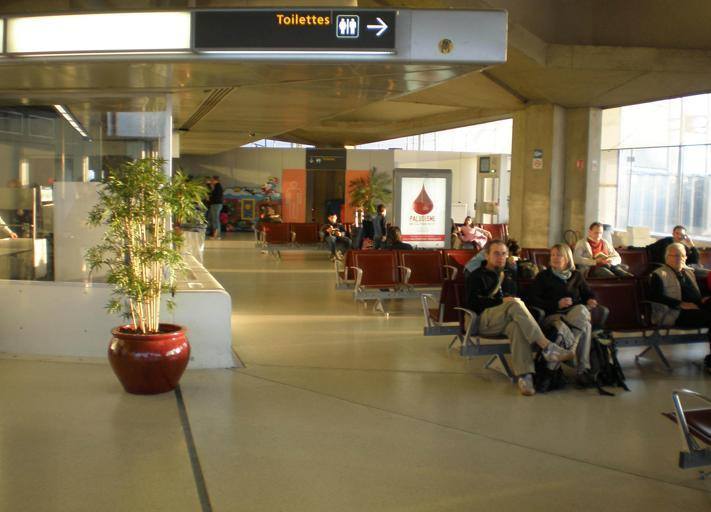

In [22]:
image = Image.open('/content/ADE20k_toy_dataset/images/training/ADE_train_00000002.jpg')
image

In [23]:
# prepare the image for the model
pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [24]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

In [25]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 128, 128])


In [26]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

In [27]:
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


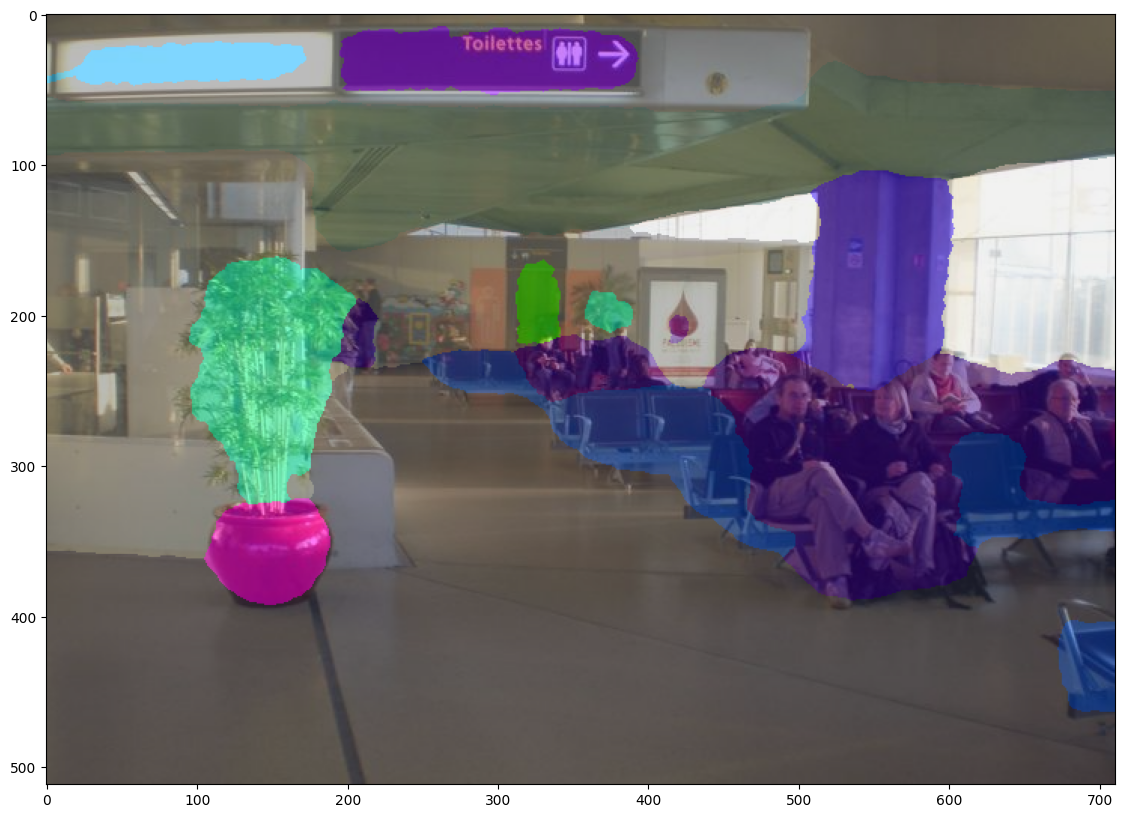

In [28]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare this to the ground truth segmentation map:

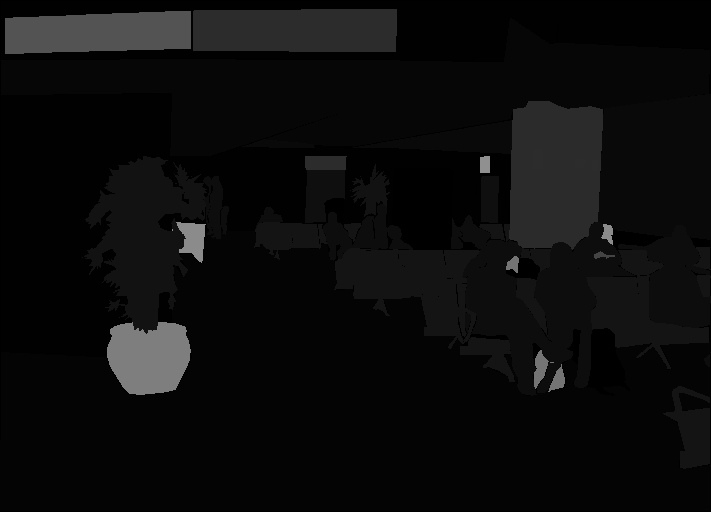

In [29]:
map = Image.open('/content/ADE20k_toy_dataset/annotations/training/ADE_train_00000002.png')
map

Classes in this image: ['wall', 'floor', 'ceiling', 'windowpane', 'person', 'door', 'plant', 'chair', 'column', 'signboard', 'book', 'light', 'bag', 'pot', 'ashcan', 'monitor', None]


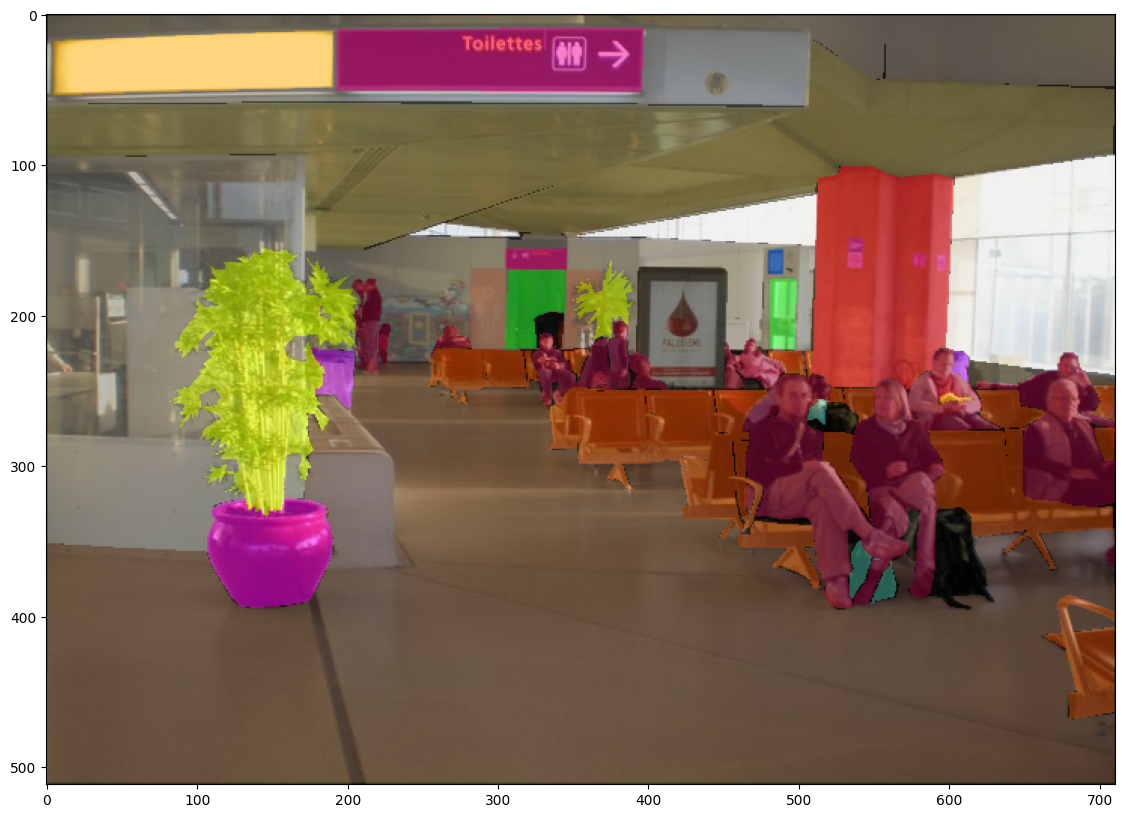

In [30]:
# convert map to NumPy array
import cv2
map = np.array(map)
map[map == 0] = 255 # background class is replaced by ignore_index
map = map - 1 # other classes are reduced by one
map[map == 254] = 255

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = cv2.resize(color_seg, (img.shape[1], img.shape[0]))

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Let's compute the metrics:

In [31]:
# metric expects a list of numpy arrays for both predictions and references
metrics = metric._compute(
                  predictions=[predicted_segmentation_map],
                  references=[map],
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

In [32]:
metrics.keys()

dict_keys(['mean_iou', 'mean_accuracy', 'overall_accuracy', 'per_category_iou', 'per_category_accuracy'])

In [33]:
import pandas as pd

# print overall metrics
for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for id, label in id2label.items():
    metric_table[label] = [
                           metrics["per_category_iou"][id],
                           metrics["per_category_accuracy"][id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])

mean_iou 0.5741739006098213
mean_accuracy 0.6179763378421482
overall_accuracy 0.9214790147884373
---------------------
per-category metrics:


IoU  accuracy
wall      0.821202  0.968858
building       NaN       NaN
sky            NaN       NaN
floor     0.963745  0.980257
tree           NaN       NaN
...            ...       ...
shower         NaN       NaN
radiator       NaN       NaN
glass          NaN       NaN
clock          NaN       NaN
flag           NaN       NaN

[150 rows x 2 columns]

In [34]:
metric_table

{'wall': [0.8212024929732372, 0.9688576824925388],
 'building': [nan, nan],
 'sky': [nan, nan],
 'floor': [0.9637446354456797, 0.9802569627324236],
 'tree': [nan, nan],
 'ceiling': [0.9341768272661602, 0.9450583519720087],
 'road': [nan, nan],
 'bed ': [nan, nan],
 'windowpane': [0.91520935620897, 0.9464856230031949],
 'grass': [nan, nan],
 'cabinet': [nan, nan],
 'sidewalk': [nan, nan],
 'person': [0.6973692995927088, 0.9279875610839626],
 'earth': [nan, nan],
 'door': [0.39920792079207923, 0.4228187919463087],
 'table': [nan, nan],
 'mountain': [nan, nan],
 'plant': [0.7685544170589864, 0.8745765382494288],
 'curtain': [nan, nan],
 'chair': [0.6448845773825563, 0.6912005391354578],
 'car': [nan, nan],
 'water': [nan, nan],
 'painting': [nan, nan],
 'sofa': [nan, nan],
 'shelf': [nan, nan],
 'house': [nan, nan],
 'sea': [nan, nan],
 'mirror': [nan, nan],
 'rug': [nan, nan],
 'field': [nan, nan],
 'armchair': [nan, nan],
 'seat': [nan, nan],
 'fence': [nan, nan],
 'desk': [nan, nan],
 

In [36]:
import pandas as pd

# Initialize an empty dictionary to accumulate metrics over epochs
epoch_metrics = {label: {'IoU': [], 'accuracy': []} for label in id2label.values()}

def save_metrics_to_csv(metrics, filename):
    global epoch_metrics

    # Append the metrics for each category to the dictionary
    for id, label in id2label.items():
        epoch_metrics[label]['IoU'].append(metrics["per_category_iou"][id])
        epoch_metrics[label]['accuracy'].append(metrics["per_category_accuracy"][id])

    # Check if it's the last epoch and write to CSV
    if epoch == 199:
        df = pd.DataFrame(epoch_metrics)
        df.to_csv(filename)

# Fine-tuning loop
for epoch in range(200):
    print("Epoch:", epoch)
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)

            # note that the metric expects predictions + labels as numpy arrays
            metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
            # currently using _compute instead of compute
            # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
            metrics = metric._compute(
                predictions=predicted.cpu(),
                references=labels.cpu(),
                num_labels=len(id2label),
                ignore_index=255,
                reduce_labels=False, # we've already reduced the labels ourselves
            )

            print("Loss:", loss.item())
            print("Mean_iou:", metrics["mean_iou"])
            print("Mean accuracy:", metrics["mean_accuracy"])

    # Save metrics to CSV after each epoch
    save_metrics_to_csv(metrics, f"segformer_epoch_metrics.csv")

Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06968841701745987
Mean_iou: 0.6147226110188437
Mean accuracy: 0.7981253116656278
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10905512422323227
Mean_iou: 0.7249933962533046
Mean accuracy: 0.7742513621651302
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.052990760654211044
Mean_iou: 0.9539803477427834
Mean accuracy: 0.9728207092325203
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1718646138906479
Mean_iou: 0.6944731229762048
Mean accuracy: 0.7207537462196856
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.15493455529212952
Mean_iou: 0.7755758646318885
Mean accuracy: 0.8132507865165786
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.19742104411125183
Mean_iou: 0.543771697589476
Mean accuracy: 0.586326392500915
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11059907078742981
Mean_iou: 0.8590359992328287
Mean accuracy: 0.9178728678982423
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06180689111351967
Mean_iou: 0.8427791313196814
Mean accuracy: 0.9714153585853587
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11085028201341629
Mean_iou: 0.8634441290257276
Mean accuracy: 0.8916064823889501
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.025483064353466034
Mean_iou: 0.9872586482329742
Mean accuracy: 0.9938507453349497
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07534687221050262
Mean_iou: 0.8436694449602842
Mean accuracy: 0.877387507258561
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08647487312555313
Mean_iou: 0.8843290321658165
Mean accuracy: 0.9101515269535023
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.03623274713754654
Mean_iou: 0.9315048053573689
Mean accuracy: 0.9393319084020546
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.13069339096546173
Mean_iou: 0.5628974263392343
Mean accuracy: 0.5973686346590362
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07186036556959152
Mean_iou: 0.6368093331526068
Mean accuracy: 0.8078595295606734
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1233292892575264
Mean_iou: 0.7039685347651429
Mean accuracy: 0.7570574989210457
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09610959887504578
Mean_iou: 0.7346882997100207
Mean accuracy: 0.7595659576866124
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06630926579236984
Mean_iou: 0.9652973187770635
Mean accuracy: 0.9845651331240634
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11623220145702362
Mean_iou: 0.7126210359595021
Mean accuracy: 0.738236799755999
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11477707326412201
Mean_iou: 0.8336663332277086
Mean accuracy: 0.861431250851942
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.023052606731653214
Mean_iou: 0.963598433167118
Mean accuracy: 0.9812252441278595
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.042550794780254364
Mean_iou: 0.613726647796301
Mean accuracy: 0.7919549579588174
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.036640625447034836
Mean_iou: 0.9357055602522989
Mean accuracy: 0.9819702092687979
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08067221194505692
Mean_iou: 0.94135974831069
Mean accuracy: 0.9687509848901761
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08833689987659454
Mean_iou: 0.8675403663635054
Mean accuracy: 0.8960839497488947
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07620739191770554
Mean_iou: 0.833142713162152
Mean accuracy: 0.8602609490094428
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0611138641834259
Mean_iou: 0.9037524827369008
Mean accuracy: 0.9222124264882647
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10193443298339844
Mean_iou: 0.8315984477548968
Mean accuracy: 0.8782722704339105
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.21394237875938416
Mean_iou: 0.5310532723033836
Mean accuracy: 0.5747801967184849
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.19326181709766388
Mean_iou: 0.6930882515497708
Mean accuracy: 0.7252733285351195
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.040539029985666275
Mean_iou: 0.9772143020179489
Mean accuracy: 0.9846872160917303
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12675945460796356
Mean_iou: 0.5770550578583232
Mean accuracy: 0.6137528014589122
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1191420704126358
Mean_iou: 0.5949371170637496
Mean accuracy: 0.6319278639618522
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11712378263473511
Mean_iou: 0.5994984727286814
Mean accuracy: 0.6379102471713839
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1216314435005188
Mean_iou: 0.5995701180332279
Mean accuracy: 0.645154217390756
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11325381696224213
Mean_iou: 0.8231311069765795
Mean accuracy: 0.8827253346421335
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08696472644805908
Mean_iou: 0.885391304513973
Mean accuracy: 0.9084913807822146
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12003041058778763
Mean_iou: 0.5879833268841587
Mean accuracy: 0.627581625731122
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1033056452870369
Mean_iou: 0.639539997347096
Mean accuracy: 0.6758855773123753
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.17504003643989563
Mean_iou: 0.7816059214846195
Mean accuracy: 0.8574098494281993
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06943076103925705
Mean_iou: 0.8753705402561566
Mean accuracy: 0.899613408285462
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.04304611682891846
Mean_iou: 0.5293952472021968
Mean accuracy: 0.7768413274340893
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.026146601885557175
Mean_iou: 0.5964688044595583
Mean accuracy: 0.7529597283295691
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07686630636453629
Mean_iou: 0.88682957125807
Mean accuracy: 0.9252999340169884
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1461155116558075
Mean_iou: 0.7191617683413679
Mean accuracy: 0.7493824753384984
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07924085855484009
Mean_iou: 0.8707482549268379
Mean accuracy: 0.9049084779268489
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0875946432352066
Mean_iou: 0.8981663502183611
Mean accuracy: 0.9441669435029214
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07688753306865692
Mean_iou: 0.9431121477462028
Mean accuracy: 0.9758978847680534
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05538322031497955
Mean_iou: 0.848114991196198
Mean accuracy: 0.9766940847962077
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11801892518997192
Mean_iou: 0.5806660887298443
Mean accuracy: 0.6166363513934856
Epoch: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.03402440994977951
Mean_iou: 0.6695471954165994
Mean accuracy: 0.8001780501108474
Epoch: 51


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08346709609031677
Mean_iou: 0.8996824375083687
Mean accuracy: 0.942568050713845
Epoch: 52


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.13665659725666046
Mean_iou: 0.5483084706561476
Mean accuracy: 0.6302790526977173
Epoch: 53


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0936768651008606
Mean_iou: 0.906262374144912
Mean accuracy: 0.955493767859331
Epoch: 54


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11407438665628433
Mean_iou: 0.7112406082946613
Mean accuracy: 0.7634902450355926
Epoch: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1842024177312851
Mean_iou: 0.5480548282220593
Mean accuracy: 0.5923894586992838
Epoch: 56


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06470854580402374
Mean_iou: 0.8763734221974872
Mean accuracy: 0.9007965175749595
Epoch: 57


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10478445887565613
Mean_iou: 0.8556438751133946
Mean accuracy: 0.8775488381585739
Epoch: 58


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.20816358923912048
Mean_iou: 0.5243259101266909
Mean accuracy: 0.6011104815264345
Epoch: 59


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12807652354240417
Mean_iou: 0.7157426398639104
Mean accuracy: 0.7474264141478306
Epoch: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1213342472910881
Mean_iou: 0.7311870257676586
Mean accuracy: 0.7577002139924012
Epoch: 61


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07334956526756287
Mean_iou: 0.8548553821809092
Mean accuracy: 0.884460294013859
Epoch: 62


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11421392112970352
Mean_iou: 0.6143684262692035
Mean accuracy: 0.6646955938950984
Epoch: 63


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05588674917817116
Mean_iou: 0.8642305037077769
Mean accuracy: 0.8869944602132691
Epoch: 64


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06423325091600418
Mean_iou: 0.8744328723064192
Mean accuracy: 0.8990841329518794
Epoch: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09187349677085876
Mean_iou: 0.7106289071416501
Mean accuracy: 0.7400709215579171
Epoch: 66


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10297755151987076
Mean_iou: 0.45908482293423075
Mean accuracy: 0.6228474896375811
Epoch: 67


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.18939319252967834
Mean_iou: 0.6935884023385662
Mean accuracy: 0.7289772196894089
Epoch: 68


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10389246046543121
Mean_iou: 0.621601350315669
Mean accuracy: 0.6593414438353522
Epoch: 69


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.119806207716465
Mean_iou: 0.41147362946583765
Mean accuracy: 0.5198783467985908
Epoch: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.039684541523456573
Mean_iou: 0.5603402664464366
Mean accuracy: 0.7300354055958741
Epoch: 71


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.15095746517181396
Mean_iou: 0.5688502520936702
Mean accuracy: 0.6783554719368184
Epoch: 72


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.03624922037124634
Mean_iou: 0.5772632681218741
Mean accuracy: 0.8008334888363834
Epoch: 73


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1331108957529068
Mean_iou: 0.6366561195957123
Mean accuracy: 0.6984365301129586
Epoch: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08804573118686676
Mean_iou: 0.8521958673264838
Mean accuracy: 0.9008676655188051
Epoch: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07089821994304657
Mean_iou: 0.9413706252097411
Mean accuracy: 0.966901132938241
Epoch: 76


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07709331810474396
Mean_iou: 0.8606802771929541
Mean accuracy: 0.8859698288477064
Epoch: 77


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11559230089187622
Mean_iou: 0.4628656419889404
Mean accuracy: 0.5885870963615968
Epoch: 78


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09053004533052444
Mean_iou: 0.7159438395875659
Mean accuracy: 0.7369267822219826
Epoch: 79


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0215842854231596
Mean_iou: 0.4473918138674869
Mean accuracy: 0.797802576205188
Epoch: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.046697892248630524
Mean_iou: 0.92952401998637
Mean accuracy: 0.9429187670613499
Epoch: 81


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.049809303134679794
Mean_iou: 0.7020262216331321
Mean accuracy: 0.8369275551767229
Epoch: 82


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12608535587787628
Mean_iou: 0.5485015282527249
Mean accuracy: 0.634618633239177
Epoch: 83


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12178345024585724
Mean_iou: 0.728734711641727
Mean accuracy: 0.7573345586959811
Epoch: 84


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.046593036502599716
Mean_iou: 0.8755908675774107
Mean accuracy: 0.8982659566105411
Epoch: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10964547097682953
Mean_iou: 0.7435858164323503
Mean accuracy: 0.7827967469734055
Epoch: 86


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.04471791535615921
Mean_iou: 0.5832038094409647
Mean accuracy: 0.7884543022223047
Epoch: 87


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.019628114998340607
Mean_iou: 0.5772410417861834
Mean accuracy: 0.8082236990440506
Epoch: 88


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07739964127540588
Mean_iou: 0.9055726608948683
Mean accuracy: 0.9518016805147218
Epoch: 89


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11984837800264359
Mean_iou: 0.7538129903103307
Mean accuracy: 0.7777862677217203
Epoch: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12468475103378296
Mean_iou: 0.5638838342594872
Mean accuracy: 0.632186214531103
Epoch: 91


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.018739400431513786
Mean_iou: 0.94667413162984
Mean accuracy: 0.9516434752393085
Epoch: 92


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0192556269466877
Mean_iou: 0.9875442048294967
Mean accuracy: 0.9950062477378727
Epoch: 93


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11758574098348618
Mean_iou: 0.6656012915098176
Mean accuracy: 0.7377828344948055
Epoch: 94


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.14306987822055817
Mean_iou: 0.7334415082922103
Mean accuracy: 0.764063219858289
Epoch: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06793126463890076
Mean_iou: 0.8650246240853916
Mean accuracy: 0.8890120581392975
Epoch: 96


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.04707704856991768
Mean_iou: 0.6998920536698807
Mean accuracy: 0.8329157364273541
Epoch: 97


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07090312987565994
Mean_iou: 0.9093441037566631
Mean accuracy: 0.949032124826794
Epoch: 98


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09508517384529114
Mean_iou: 0.5202042278287985
Mean accuracy: 0.6410734574941285
Epoch: 99


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.052551403641700745
Mean_iou: 0.9559025258347591
Mean accuracy: 0.970626218533881
Epoch: 100


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10019668191671371
Mean_iou: 0.7614279848580354
Mean accuracy: 0.7873232316762787
Epoch: 101


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0785692110657692
Mean_iou: 0.7451690306380157
Mean accuracy: 0.7717461947337879
Epoch: 102


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.04022141173481941
Mean_iou: 0.9642349573505279
Mean accuracy: 0.9767185216401812
Epoch: 103


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11948885023593903
Mean_iou: 0.7185309020861996
Mean accuracy: 0.7748258246956045
Epoch: 104


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10655195266008377
Mean_iou: 0.7500992955621437
Mean accuracy: 0.7744440934139315
Epoch: 105


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.01735619455575943
Mean_iou: 0.9625965673594664
Mean accuracy: 0.9741985149306146
Epoch: 106


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.03378814831376076
Mean_iou: 0.936787568770864
Mean accuracy: 0.9860531716478105
Epoch: 107


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.113568015396595
Mean_iou: 0.7677109034464444
Mean accuracy: 0.7928701886595362
Epoch: 108


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.04713477939367294
Mean_iou: 0.86302876829359
Mean accuracy: 0.9092665164413025
Epoch: 109


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07774949818849564
Mean_iou: 0.7557154142961356
Mean accuracy: 0.7798118686915447
Epoch: 110


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10038571804761887
Mean_iou: 0.6529362880478954
Mean accuracy: 0.6974765240131351
Epoch: 111


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08376770466566086
Mean_iou: 0.8713209779667491
Mean accuracy: 0.9008959853181165
Epoch: 112


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.030233604833483696
Mean_iou: 0.6093081389980469
Mean accuracy: 0.8275110582777268
Epoch: 113


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.045949846506118774
Mean_iou: 0.8711208189651084
Mean accuracy: 0.8943249050649437
Epoch: 114


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05944089964032173
Mean_iou: 0.9003959994739942
Mean accuracy: 0.9228523503708486
Epoch: 115


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09232767671346664
Mean_iou: 0.7482140367460671
Mean accuracy: 0.7726142284277585
Epoch: 116


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.034587420523166656
Mean_iou: 0.6274652269616806
Mean accuracy: 0.8268310194457275
Epoch: 117


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09355337172746658
Mean_iou: 0.8096010381310506
Mean accuracy: 0.8468760490565859
Epoch: 118


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1544203907251358
Mean_iou: 0.6596659114979498
Mean accuracy: 0.7293858995830639
Epoch: 119


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.04584755003452301
Mean_iou: 0.8497238610205204
Mean accuracy: 0.9782961052512594
Epoch: 120


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07942933589220047
Mean_iou: 0.7478286241820506
Mean accuracy: 0.7721044233450022
Epoch: 121


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09821411222219467
Mean_iou: 0.8809980174446225
Mean accuracy: 0.9484703966522086
Epoch: 122


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09927261620759964
Mean_iou: 0.6468656403877
Mean accuracy: 0.7311465016967598
Epoch: 123


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10431475937366486
Mean_iou: 0.7003736602364835
Mean accuracy: 0.7365274766327707
Epoch: 124


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.046453479677438736
Mean_iou: 0.7410232756638869
Mean accuracy: 0.8256853056222322
Epoch: 125


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10908827185630798
Mean_iou: 0.7511703045400179
Mean accuracy: 0.7762809502142296
Epoch: 126


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0972118079662323
Mean_iou: 0.7329903245229071
Mean accuracy: 0.7610932898575221
Epoch: 127


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08612456917762756
Mean_iou: 0.6763623019083753
Mean accuracy: 0.7269695685361293
Epoch: 128


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0445270799100399
Mean_iou: 0.7500073188501145
Mean accuracy: 0.8365733469026261
Epoch: 129


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.03568749502301216
Mean_iou: 0.9000880197013478
Mean accuracy: 0.9396830286555377
Epoch: 130


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07746712863445282
Mean_iou: 0.7486998226310909
Mean accuracy: 0.7758428690359431
Epoch: 131


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12297424674034119
Mean_iou: 0.6310972679553882
Mean accuracy: 0.6664595957553259
Epoch: 132


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06275251507759094
Mean_iou: 0.7658405119578832
Mean accuracy: 0.9782761248335466
Epoch: 133


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08907368779182434
Mean_iou: 0.7616624971235757
Mean accuracy: 0.8035803527093491
Epoch: 134


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.020795995369553566
Mean_iou: 0.9556514156465162
Mean accuracy: 0.9659124041917999
Epoch: 135


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.035472456365823746
Mean_iou: 0.9053547675709872
Mean accuracy: 0.9421168439852395
Epoch: 136


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05977039411664009
Mean_iou: 0.8992146288327989
Mean accuracy: 0.9212685956822144
Epoch: 137


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.03851578012108803
Mean_iou: 0.9631510721997116
Mean accuracy: 0.9843858718313933
Epoch: 138


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08900973200798035
Mean_iou: 0.516778861755609
Mean accuracy: 0.6674682296703927
Epoch: 139


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07950199395418167
Mean_iou: 0.9237684310927126
Mean accuracy: 0.9593164371007746
Epoch: 140


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07514476776123047
Mean_iou: 0.7738729622377868
Mean accuracy: 0.8001449447510129
Epoch: 141


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1255275309085846
Mean_iou: 0.6402360043545444
Mean accuracy: 0.6796834412329887
Epoch: 142


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08788523823022842
Mean_iou: 0.6696017710899387
Mean accuracy: 0.7060828608992831
Epoch: 143


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.03055637516081333
Mean_iou: 0.9569825712998935
Mean accuracy: 0.9778304677370673
Epoch: 144


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.033870797604322433
Mean_iou: 0.7167306043298605
Mean accuracy: 0.8052414718218989
Epoch: 145


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12745709717273712
Mean_iou: 0.6572523364611795
Mean accuracy: 0.7468322817695413
Epoch: 146


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0848553255200386
Mean_iou: 0.7379237199768729
Mean accuracy: 0.7599564126437305
Epoch: 147


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11184083670377731
Mean_iou: 0.6864236389300343
Mean accuracy: 0.7215261413974284
Epoch: 148


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07933476567268372
Mean_iou: 0.6990408090873589
Mean accuracy: 0.7420934431935143
Epoch: 149


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07116004079580307
Mean_iou: 0.7827780008866958
Mean accuracy: 0.8187792163146265
Epoch: 150


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07659492641687393
Mean_iou: 0.8945416767880765
Mean accuracy: 0.9404667250889819
Epoch: 151


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08056788891553879
Mean_iou: 0.8413323144670288
Mean accuracy: 0.8896653963120605
Epoch: 152


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05903979018330574
Mean_iou: 0.8438794969496484
Mean accuracy: 0.8958650083620701
Epoch: 153


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11525221168994904
Mean_iou: 0.5664908466980914
Mean accuracy: 0.5961637529972529
Epoch: 154


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07047943025827408
Mean_iou: 0.7575764343365159
Mean accuracy: 0.782358959897198
Epoch: 155


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.022657647728919983
Mean_iou: 0.5187605864382849
Mean accuracy: 0.7903700554037605
Epoch: 156


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06165798753499985
Mean_iou: 0.8672031065809438
Mean accuracy: 0.895849058395147
Epoch: 157


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.016963759437203407
Mean_iou: 0.9894402155369084
Mean accuracy: 0.9948642947345647
Epoch: 158


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10090414434671402
Mean_iou: 0.6839366694962244
Mean accuracy: 0.7784270706071782
Epoch: 159


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05239835008978844
Mean_iou: 0.791003884872691
Mean accuracy: 0.8189394977927905
Epoch: 160


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07258088886737823
Mean_iou: 0.8850686408707675
Mean accuracy: 0.9105275444211921
Epoch: 161


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0769396722316742
Mean_iou: 0.7582114003481613
Mean accuracy: 0.7831184845972811
Epoch: 162


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08782605826854706
Mean_iou: 0.9126326574291272
Mean accuracy: 0.9554945302441181
Epoch: 163


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08839061856269836
Mean_iou: 0.8468089710255898
Mean accuracy: 0.8875317224052403
Epoch: 164


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06007896363735199
Mean_iou: 0.9120406063031675
Mean accuracy: 0.9527341124192626
Epoch: 165


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1011020690202713
Mean_iou: 0.7069878923908742
Mean accuracy: 0.7466830711326276
Epoch: 166


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1003735288977623
Mean_iou: 0.7031681973370751
Mean accuracy: 0.7403508516171163
Epoch: 167


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08428958058357239
Mean_iou: 0.7681542929615541
Mean accuracy: 0.8027449390061541
Epoch: 168


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05399475246667862
Mean_iou: 0.9021717656697463
Mean accuracy: 0.9219792165914301
Epoch: 169


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.050476063042879105
Mean_iou: 0.9546108193495472
Mean accuracy: 0.9801592661620492
Epoch: 170


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.039167579263448715
Mean_iou: 0.9539792369804381
Mean accuracy: 0.9865890860504697
Epoch: 171


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10253844410181046
Mean_iou: 0.5275929598585726
Mean accuracy: 0.5833306557653607
Epoch: 172


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.039192840456962585
Mean_iou: 0.8090956316400175
Mean accuracy: 0.8335071002841291
Epoch: 173


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05030643194913864
Mean_iou: 0.8854687290969494
Mean accuracy: 0.907423154089446
Epoch: 174


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.025800731033086777
Mean_iou: 0.6882044638297056
Mean accuracy: 0.8268353472413792
Epoch: 175


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09467966854572296
Mean_iou: 0.6262411945208541
Mean accuracy: 0.7237204158445503
Epoch: 176


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.04736201465129852
Mean_iou: 0.9469682958612535
Mean accuracy: 0.9870287342355107
Epoch: 177


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07726383209228516
Mean_iou: 0.7278800544360231
Mean accuracy: 0.7737416040049026
Epoch: 178


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12201185524463654
Mean_iou: 0.5863221160460018
Mean accuracy: 0.6495670160926666
Epoch: 179


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.04941582679748535
Mean_iou: 0.8853059401749066
Mean accuracy: 0.9047211767021422
Epoch: 180


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.028369376435875893
Mean_iou: 0.6870798977475149
Mean accuracy: 0.8383440319089525
Epoch: 181


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.045617200434207916
Mean_iou: 0.9427108502672682
Mean accuracy: 0.9681728698232326
Epoch: 182


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.023324554786086082
Mean_iou: 0.9579794322115566
Mean accuracy: 0.9868947363176122
Epoch: 183


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09762696176767349
Mean_iou: 0.7204378856000138
Mean accuracy: 0.7563480229754863
Epoch: 184


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08928616344928741
Mean_iou: 0.6243587613288767
Mean accuracy: 0.6658735014300863
Epoch: 185


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06715747714042664
Mean_iou: 0.8965232233334957
Mean accuracy: 0.947466643294694
Epoch: 186


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.035831667482852936
Mean_iou: 0.8904613568877726
Mean accuracy: 0.9008270191228218
Epoch: 187


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0946158915758133
Mean_iou: 0.7724239027148383
Mean accuracy: 0.8000503748416644
Epoch: 188


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11186577379703522
Mean_iou: 0.6646078490415985
Mean accuracy: 0.7012906258221686
Epoch: 189


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09790560603141785
Mean_iou: 0.7295702184094833
Mean accuracy: 0.7478840167789188
Epoch: 190


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08119895309209824
Mean_iou: 0.7972532565890293
Mean accuracy: 0.8273483708453303
Epoch: 191


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.022992946207523346
Mean_iou: 0.9529033902413289
Mean accuracy: 0.9853142865193831
Epoch: 192


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.052645377814769745
Mean_iou: 0.9408155281228316
Mean accuracy: 0.9680417033152001
Epoch: 193


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.022472064942121506
Mean_iou: 0.7032315304206477
Mean accuracy: 0.8459106741786985
Epoch: 194


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06210663914680481
Mean_iou: 0.8896005105549669
Mean accuracy: 0.9156321039521835
Epoch: 195


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.03498521447181702
Mean_iou: 0.8248874299560084
Mean accuracy: 0.8478198388733605
Epoch: 196


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.04900616407394409
Mean_iou: 0.9318041842618001
Mean accuracy: 0.9487326334751506
Epoch: 197


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09151748567819595
Mean_iou: 0.661344253693938
Mean accuracy: 0.7310875007867702
Epoch: 198


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05581396445631981
Mean_iou: 0.8694454081874682
Mean accuracy: 0.9026584560750517
Epoch: 199


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05815289914608002
Mean_iou: 0.7003147948815084
Mean accuracy: 0.72634192329114
